# Deep Convolutionan AutoEncoder - Dimensionality Reduction of CIFAR100 DataSet
Compare the lossy ratio between multiple latent spaces on the cifar100 dataset. Followed by its latent space, presented as 2D data. Higher dimension are reduced with  

In [ ]:
%pip install -q imageio pydot tensorflow-gpu==2.9.3 keras matplotlib graphviz moviepy

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os.path
import PIL
import PIL.Image
import keras_tuner as kt
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier


/media/programming/projects/machineLearning/ML/venv/lib/python3.8/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


## Import all Modules and Configure GPU

In [3]:
#os.environ["CUDA_VISIBLE_DEVICES"]="-1"  # Debug only
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Initialize tf.distribute.MirroredStrategy
strategy = tf.distribute.MirroredStrategy(devices=None)
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


2023-03-17 14:26:52.652417: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-17 14:26:52.824224: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-17 14:26:52.824420: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-17 14:26:52.832959: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [4]:
print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.9.3


### Configure Output Directory
Set the output directory where all the results will be storaged.

In [5]:
root_dir = "result/cifar_100_autoencoder_dimensionality_reduction"
if not os.path.exists(root_dir):
    os.mkdir(root_dir)


## Load DataSet
The following will load the default cifar100 dataset.

In [6]:

def loadDataCifar100():
    (train_images, train_labels), (test_images,
                                   test_labels) = tf.keras.datasets.cifar100.load_data(label_mode='fine'
                                                                                       )

    class_names = [
        "apple",
        "aquarium_fish",
        "baby",
        "bear",
        "beaver",
        "bed",
        "bee",
        "beetle",
        "bicycle",
        "bottle",
        "bowl",
        "boy",
        "bridge",
        "bus",
        "butterfly",
        "camel",
        "can",
        "castle",
        "caterpillar",
        "cattle",
        "chair",
        "chimpanzee",
        "clock",
        "cloud",
        "cockroach",
        "couch",
        "crab",
        "crocodile",
        "cup",
        "dinosaur",
        "dolphin",
        "elephant",
        "flatfish",
        "forest",
        "fox",
        "girl",
        "hamster",
        "house",
        "kangaroo",
        "keyboard",
        "lamp",
        "lawn_mower",
        "leopard",
        "lion",
        "lizard",
        "lobster",
        "man",
        "maple_tree",
        "motorcycle",
        "mountain",
        "mouse",
        "mushroom",
        "oak_tree",
        "orange",
        "orchid",
        "otter",
        "palm_tree",
        "pear",
        "pickup_truck",
        "pine_tree",
        "plain",
        "plate",
        "poppy",
        "porcupine",
        "possum",
        "rabbit",
        "raccoon",
        "ray",
        "road",
        "rocket",
        "rose",
        "sea",
        "seal",
        "shark",
        "shrew",
        "skunk",
        "skyscraper",
        "snail",
        "snake",
        "spider",
        "squirrel",
        "streetcar",
        "sunflower",
        "sweet_pepper",
        "table",
        "tank",
        "telephone",
        "television",
        "tiger",
        "tractor",
        "train",
        "trout",
        "tulip",
        "turtle",
        "wardrobe",
        "whale",
        "willow_tree",
        "wolf",
        "woman",
        "worm"]

    TrainX = np.concatenate((train_images, test_images))
    TrainY = np.squeeze(np.concatenate((train_labels, test_labels)))

    TrainX = TrainX / 255.0

    return TrainX, TrainY, class_names


Setup

In [7]:
#
EPOCHS = 96
BUFFER_SIZE = 192

#
BATCH_SIZE_PER_REPLICA = 64
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

trainAug = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomZoom(
        height_factor=(-0.05, -0.10),
        width_factor=(-0.05, -0.10)),
    layers.RandomRotation(0.4)
])

trainX, trainY, classes = loadDataCifar100()
trainDS = tf.data.Dataset.from_tensor_slices((trainX, trainX))

def AgumentFunc(x, y):
    aX = trainAug(x)
    return (aX, aX)

# apply augmentation image transformation to prevent overfitting of
trainAugmentedDS = (
    trainDS
    .batch(BATCH_SIZE)
    .map(AgumentFunc,
         num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

#Split data into train and validation
ds_size = len(trainAugmentedDS)
train_size = int(0.8 * ds_size)
val_size = int(0.2 * ds_size)
#Split data into train and validation
train_ds = trainAugmentedDS.take(train_size)
val_ds = trainAugmentedDS.skip(train_size).take(val_size)

# Setup to support multiple GPUs
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
train_ds = train_ds.with_options(options)
# Setup to support multiple GPUs
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
val_ds = val_ds.with_options(options)

# 
IMAGE_SIZE = trainX[0].shape


## Show Example of DataSet

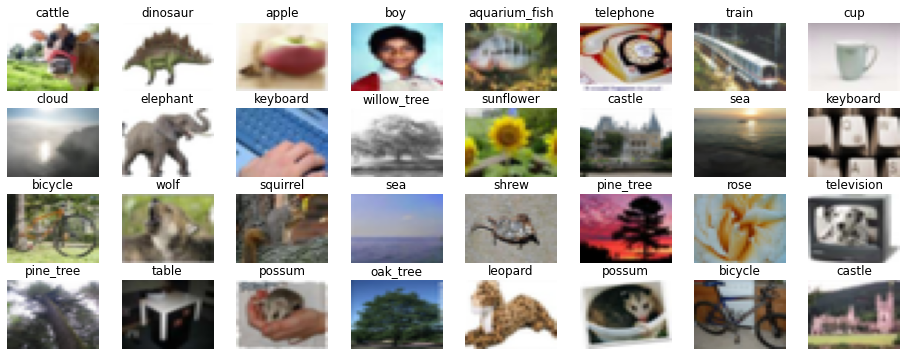

In [8]:
fig = plt.figure(figsize=(16, 6))
nrImage = 4 * 8
for index, (image, label) in enumerate(zip(trainX[0:nrImage], trainY[0:nrImage])):
    plt.subplot(4, 8, (index + 1))
    plt.title(label=str.format("{0}", classes[label]))

    plt.imshow(X=image.astype(dtype='float32'), aspect='auto')
    plt.axis("off")
plt.subplots_adjust(wspace=0.25, hspace=0.25)
plt.show(block=False)


## Augmented DataSet Example
Show example data in their augmented form.

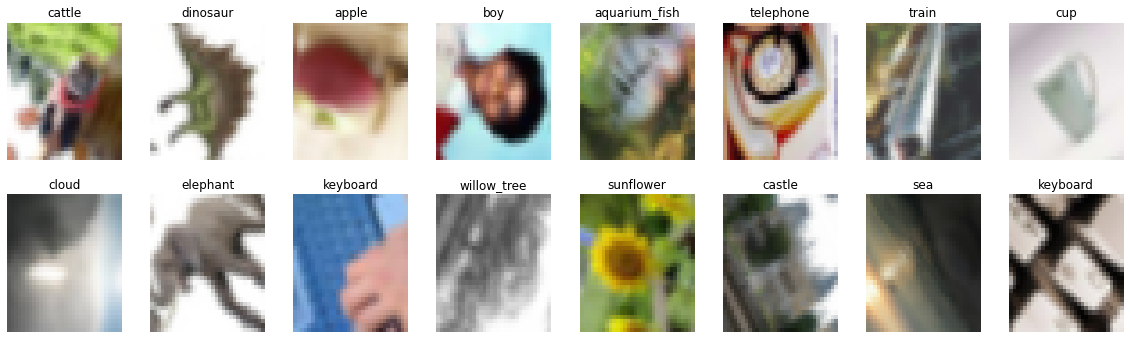

In [9]:
bathc_iter = iter(trainAugmentedDS)
image_batch, expected_batch = next(bathc_iter)

nrCol = 16
plt.figure(figsize=(10 * 2, 12))
for i in range(0, nrCol):

    trainImage, label = (image_batch[i % len(image_batch)], expected_batch[i % len(expected_batch)])  # (images + 1.0) / 2.0
    # Transform pixel values from [-1,1] to [0,1]

    plt.subplot(4, 8, (i + 1))
    plt.title(label=str.format("{0}", classes[trainY[i]]))

    plt.imshow(X=trainImage.numpy().astype(dtype='float32') , cmap=plt.cm.gray, aspect='auto')
    plt.axis("off")

    if (i + 1) % len(image_batch) == 0:
        image_batch, expected_batch = next(bathc_iter)
plt.subplots_adjust(wspace=0.25, hspace=0.25)
plt.show()


# Create Dimensionality Reduction Model
The model constructor is based on using hyperparamaters to find the best network combination that yields the best result. 

In [14]:
def model_constructor(hp, latent_space, image_size):

    class Autoencoder(keras.Model):
        def __init__(self, hp, **kwargs):
            super(Autoencoder, self).__init__(**kwargs)

            activation_dict = {
                'leaky_relu': layers.LeakyReLU(alpha=0.2, dtype='float32'),
                'relu': layers.ReLU(dtype='float32')
            }

            batch_norm = hp.Boolean('batch_norm')

            use_resnet = hp.Boolean('use_resnet')

            kernel_init = hp.Choice('kernel_initializer', ['uniform', 'lecun_uniform', 'normal', 'zero',
                                                           'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform'])
            kernel_activation = hp.Choice('kernel_activation', ['relu', 'leaky_relu'])

            hp_kernel_filter_size_l1 = hp.Int('kernel_filter', min_value=4, max_value=6, step=1)
            hp_kernel_size = hp.Int('kernel_size', min_value=3, max_value=5, step=1)

            number_layers = hp.Int(
                'number_layers', min_value=1, max_value=2, step=1)

            regularization = hp.Int(
                'regularization', min_value=4, max_value=5, step=1)

            encoder_last_conv2 = None

            self.encoder = keras.layers.Input(shape=image_size, name="AE_input")

            x = layers.Conv2D(2 ** (hp_kernel_filter_size_l1), (5, 5), strides=1, padding='same', kernel_initializer=kernel_init)(self.encoder)
            if batch_norm:
                x = layers.BatchNormalization(dtype='float32')(x)
            x = layers.ReLU(dtype='float32')(x)

            lastSumLayer = x

            for i in range(0, number_layers):
                filter_size = 2 ** (i + hp_kernel_filter_size_l1)

                x = layers.Conv2D(filter_size, (3, 3), strides=1, padding='same', kernel_initializer=kernel_init)(x)
                if batch_norm:
                    x = layers.BatchNormalization(dtype='float32')(x)
                x = layers.ReLU(dtype='float32')(x)

                x = layers.Conv2D(filter_size, (3, 3), padding='same', strides=1, kernel_initializer=kernel_init)(x)
                if batch_norm:
                    x = layers.BatchNormalization(dtype='float32')(x)
                x = layers.ReLU(dtype='float32')(x)

                x = layers.Conv2D(filter_size, (3, 3), padding='same', strides=2, kernel_initializer=kernel_init)(x)
                if batch_norm:
                    x = layers.BatchNormalization(dtype='float32')(x)
                x = layers.ReLU(dtype='float32')(x)

                AttachLayer = x
                if use_resnet:
                    if lastSumLayer is not None:
                        lastSumLayer = layers.Conv2D(filters=filter_size, kernel_size=(1, 1), kernel_initializer=kernel_init, strides=(2, 2))(lastSumLayer)
                        encoder_last_conv2 = lastSumLayer
                        x = layers.add([AttachLayer, lastSumLayer])

                    lastSumLayer = x
                    x = layers.ReLU(dtype='float32')(x)

            connect_conv_shape = x.shape

            # Flatten to connect to forward neuron.
            x = layers.Flatten()(x)

            # For adding sparse, for improve of thing with small variance.
            x = layers.Dense(units=latent_space, activation=None, bias_initializer=None, kernel_initializer=None,
                             activity_regularizer=keras.regularizers.L1(10 ** -regularization), dtype='float32', name="latentspace")(x)

            self.decoder = layers.Dense(units=(connect_conv_shape[1] * connect_conv_shape[2] * connect_conv_shape[3]),
                                        activation=None, bias_initializer=None, kernel_initializer=None, dtype='float32')(x)
            x = self.decoder

            if batch_norm:
                x = layers.BatchNormalization(dtype='float32')(x)

            x = layers.Reshape(target_shape=(
                connect_conv_shape[1], connect_conv_shape[2], connect_conv_shape[3]))(x)

            lastSumLayer = None
            for i in range(0, number_layers):
                filter_size = 2 ** (hp_kernel_filter_size_l1 + number_layers - i)

                #model.add(layers.Conv2D(filter_size, (2, 2), strides=(2, 2), activation='relu', padding='same'))
                x = layers.UpSampling2D(size=(2, 2))(x)

                x = layers.Conv2D(filter_size, (3, 3), padding='same', kernel_initializer=kernel_init)(x)
                if batch_norm:
                    x = layers.BatchNormalization(dtype='float32')(x)
                x = layers.ReLU(dtype='float32')(x)

                x = layers.Conv2D(filter_size, (3, 3), padding='same', kernel_initializer=kernel_init)(x)
                if batch_norm:
                    x = layers.BatchNormalization(dtype='float32')(x)
                x = layers.ReLU(dtype='float32')(x)

                AttachLayer = x
                if use_resnet:
                    if lastSumLayer is not None:
                        lastSumLayer = layers.Conv2DTranspose(filters=filter_size, kernel_size=(
                            1, 1), kernel_initializer=kernel_init, strides=(2, 2))(lastSumLayer)
                        x = layers.add([AttachLayer, lastSumLayer])
                    lastSumLayer = x
                    x = layers.ReLU(dtype='float32')(x)

            x = layers.Conv2D(filters=3, kernel_size=(3, 3), padding='same', kernel_initializer=kernel_init)(x)
            if batch_norm:
                x = layers.BatchNormalization(dtype='float32')(x)
            self.decoderOutput = layers.Activation(activation='sigmoid', dtype='float32')(x)

            self.model = keras.Model(inputs=self.encoder, outputs=self.decoderOutput)

        def call(self, x):
            return self.model(x)

        def getEncoder(self):
            return self.encoder

        def getDecoder(self):
            return self.decoder

        def getModel(self):
            return self.model

        def compile(self, **kwargs):
            super(Autoencoder, self).compile(**kwargs)
            self.model.compile(**kwargs)

        def summary(self, **kwargs):
            super(Autoencoder, self).summary(**kwargs)
            self.encoder.summary()

    autoencoder = Autoencoder(hp)
    hp_optimizer = hp.Choice('optimizer', ['sgd', 'adam', 'rmsprop'])
    hp_learning_rate = hp.Choice('learning_rate', values=[2e-2, 2e-3, 2e-4])

    optimizer = tf.keras.optimizers.get(hp_optimizer)
    optimizer.learning_rate = hp_learning_rate

    autoencoder.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])
    autoencoder.build((None, image_size[0], image_size[1], image_size[2]))

    return autoencoder


### Functions To Present Each Epoch Result

In [15]:
def showResult(model, batchImage, maxNumImages=6):
    output = model.predict(batchImage, verbose=0)
    nrElements = min(len(output), maxNumImages)

    batch_iter = iter(batchImage)
    image_batch, _ = next(batch_iter)

    fig = plt.figure(figsize=(maxNumImages * 2, 2 * 2))
    for i in range(nrElements):

        ax = plt.subplot(2, maxNumImages, i + 1)
        plt.imshow(np.asarray(image_batch[i % len(image_batch)]).astype(dtype='float32'))
        plt.axis("off")

        if len(image_batch) - 1 == i:
            image_batch, _ = next(batch_iter)
    fig.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.close()
    return fig


class save_images(tf.keras.callbacks.Callback):

    def __init__(self, dir_path, latent_space, trainData, **kwargs):
        super(tf.keras.callbacks.Callback, self).__init__(**kwargs)
        self.trainSet = trainData.take(2)
        self.latent_space = latent_space
        self.dir_path = dir_path
        if not os.path.exists(self.dir_path):
            os.mkdir(self.dir_path)

    def on_epoch_end(self, epoch, logs=None):
        fig = showResult(self.model, self.trainSet)
        fig.savefig(os.path.join(self.dir_path, "AECifar100DimRedL{0}_{1}.png".format(self.latent_space, epoch)))
        fig = showResult(self.model, self.trainSet, 12)
        fig.savefig(os.path.join(self.dir_path, "AECifar100DimRedBigL{1}_{2}.png".format(self.latent_space, epoch)))


In [16]:


class SaveTrailImageResultCallback(tf.keras.callbacks.Callback):

    def __init__(self, tuner, **kwargs):
        super(tf.keras.callbacks.Callback, self).__init__(**kwargs)
        self.tuner = tuner

    def on_epoch_begin(self, epoch, logs=None):
        pass

    def on_epoch_end(self, epoch, logs=None):
        state = self.tuner.get_state()
        fig = showResult(self.model, val_ds.take(20))
        index = 0
        if len(self.tuner.oracle.start_order) > 0:
            index = self.tuner.oracle.start_order[-1]
        fig.savefig(os.path.join(self.tuner.get_trial_dir(index), str.format(root_dir, 'ImageAtEpoch{0}.png', epoch)))


## Hyperparameter
Find the best model out of all the parameters.

In [17]:

image_shape = (trainX[0].shape[0], trainX[0].shape[1], 3)

latent_spaces = [1, 2, 4, 8, 16, 32, 64, 128]
ae_models = []

for latent_space in reversed(latent_spaces):

    def hyperparamter_model_builder(hp):
        model = model_constructor(hp, latent_space, image_shape)
        tf.keras.utils.plot_model(
            model, to_file=os.path.join(root_dir, str.format('cnn_{0}_model.png', "Cifar100")), show_shapes=True, show_dtype=True,
            show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96,
            layer_range=None
        )
        return model

    tuner = kt.Hyperband(hyperparamter_model_builder,
                         objective='val_accuracy',
                         distribution_strategy=strategy,
                         max_epochs=16,
                         factor=4,
                         directory=os.path.join(root_dir, 'cache'),
                         project_name=str.format('CIFAR100 AutoEncoder Reconstruct L{0} - {1}', latent_space, "Dimension Reduction"))

    stop_early = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=3)

    tuner.search(train_ds, epochs=EPOCHS, shuffle=True, batch_size=BATCH_SIZE,
                 callbacks=[stop_early, tf.keras.callbacks.TerminateOnNaN(), SaveTrailImageResultCallback(tuner)], validation_data=val_ds, verbose=1)

    ae_models.append(tuner.get_best_models(num_models=1)[0])


Trial 13 Complete [00h 00m 41s]
val_accuracy: 0.5408597588539124

Best val_accuracy So Far: 0.5543280839920044
Total elapsed time: 00h 09m 26s

Search: Running Trial #14

Value             |Best Value So Far |Hyperparameter
True              |False             |batch_norm
True              |False             |use_resnet
lecun_uniform     |lecun_uniform     |kernel_initializer
leaky_relu        |leaky_relu        |kernel_activation
4                 |6                 |kernel_filter
4                 |3                 |kernel_size
1                 |2                 |number_layers
4                 |5                 |regularization
rmsprop           |sgd               |optimizer
0.02              |0.02              |learning_rate
1                 |1                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
0                 |0                 |tuner/round

747/750 [============================>.] - ETA

## Train Finalize Model
For each of the best preliminary latent space result, perform a full training. 

In [ ]:
model_results = []
EPOCHS = 32


for latent_space, ae_model in zip(latent_spaces, ae_models):

    # Construct the checkpoint path for specific latent space size.
    checkpoint_path = os.path.join(root_dir, str.format("checkpoints/AE_Cifar100_l{0}_Reconstruction/cp.ckpt", latent_space))

    # Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                     save_weights_only=True,
                                                     verbose=0)

    checkpoint = tf.train.Checkpoint(model=ae_model)
    checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path)).expect_partial()

    # The model weights (that are considered the best) are loaded into the model.
    if os.path.exists(checkpoint_path):
        ae_model.load_weights(checkpoint_path)

    model_history = ae_model.fit(train_ds,
                                 epochs=EPOCHS,
                                 batch_size=BATCH_SIZE,
                                 shuffle=True,
                                 validation_data=val_ds,
                                 verbose=2, callbacks=[cp_callback, save_images(os.path.join(root_dir, str.format("AE_Cifar100_latent_{0}", latent_space), latent_space, val_ds))])
    # Save the results.
    model_results.append(model_history)

    # Save weights.
    ae_model.save_weights(checkpoint_path)

    del ae_model


## Performance Evolution
Presents all of the latent space loss and accuracy.

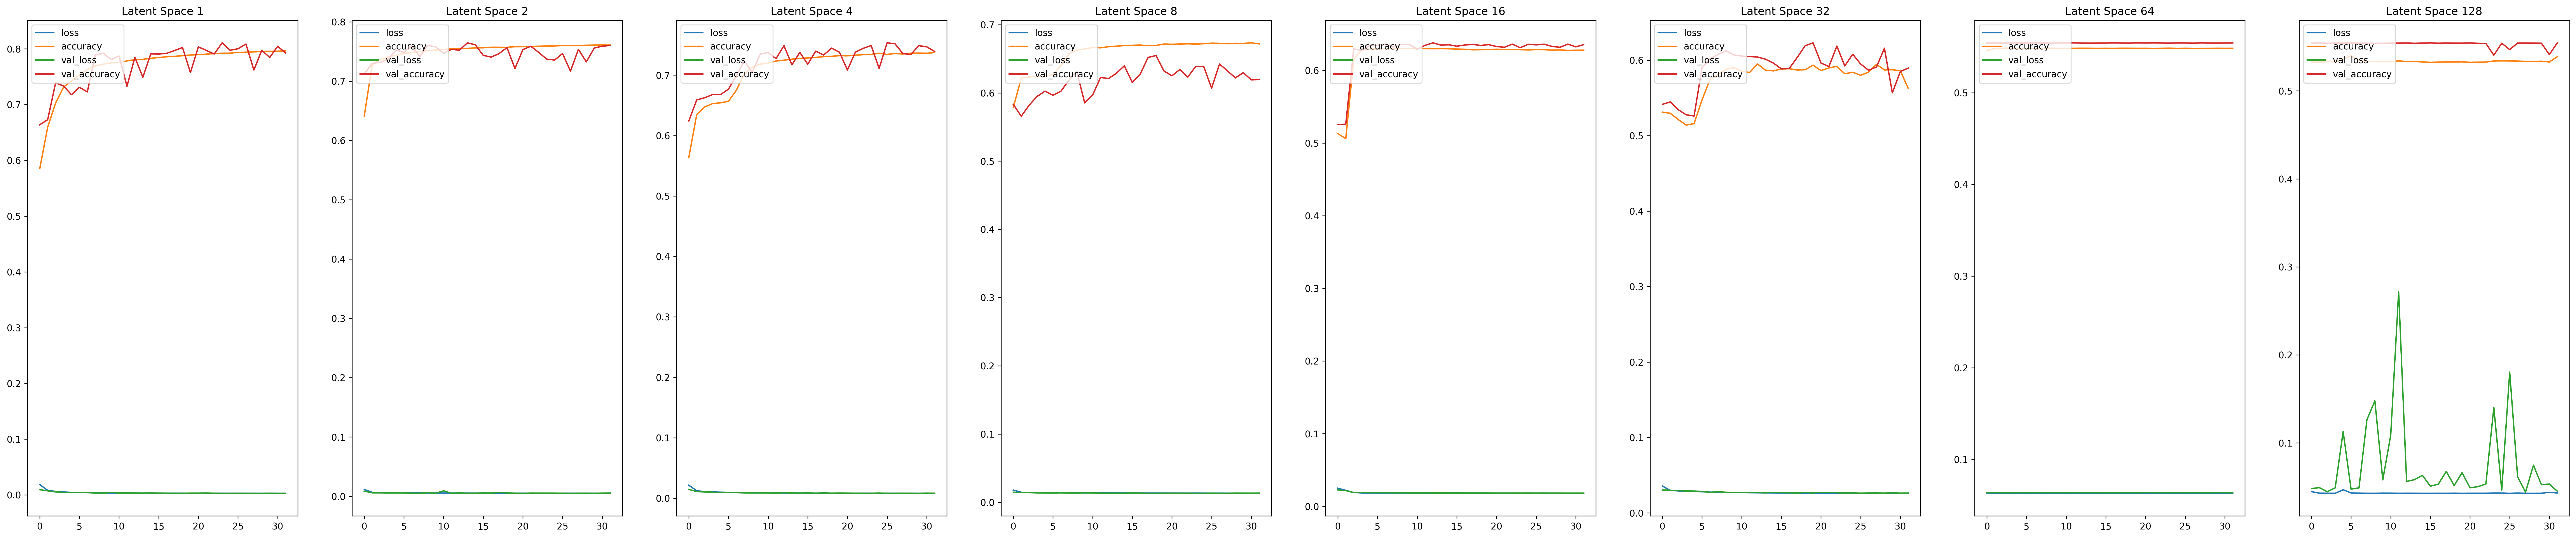

<Figure size 432x288 with 0 Axes>

In [ ]:
def plotCostHistories(results, loss_label="", val_label="", title="", x_label="", y_label=""):
    fig = plt.figure(figsize=(len(results) * 6.25, 10), dpi=300)
    for i, (latent_space, result) in enumerate(zip(latent_spaces, results)):
        ax = plt.subplot(1, len(results), i + 1)
        for k, v in result.history.items():
            plt.plot(v, label=k)
        ax.title.set_text(str.format('Latent Space {0}', latent_space))

        plt.ylabel(ylabel=y_label)
        plt.xlabel(xlabel=x_label)
        plt.legend(loc="upper left")
    plt.show(block=False)
    plt.savefig(title + ".png")


plotCostHistories(model_results, title=str.format(
    "CNN {0} Performance History", "Fashion"))


## Compare Result
The following compares the original and resulted reconstructed results in respect to each lantent spaces.

In [ ]:
# Plot Result
predictData = trainX[0:9]

fig = plt.figure(figsize=(len(ae_models) * 3 * 4, 3*4), dpi=300)
main_outer = fig.add_gridspec(1, len(ae_models), wspace=0.05, hspace=0.05)

for i, (lantent_space, model) in enumerate(zip(latent_spaces, ae_models)):

    result = model.predict(predictData, batch_size=256, verbose=0)
    encoder_model = model.getEncoder()

    outer = main_outer[i].subgridspec(3, 3, wspace=0.02, hspace=0.02)

    for a in range(3):
        for b in range(3):
            inner = outer[a, b].subgridspec(1, 2, wspace=0, hspace=0)

            axs = inner.subplots()  # Create all subplots for the inner grid.
            for (d,), ax in np.ndenumerate(axs):
                ax.grid(False)
                ax.axis("off")
                if d == 0:
                    ax.imshow(trainX[b * 2 + a])
                    ax.set_title('Train Data')
                else:
                    ax.imshow(result[b * 2 + a])
                    ax.set_title('Reconstructed')

for ax in fig.get_axes():
    ss = ax.get_subplotspec()
    ax.spines.top.set_visible(ss.is_first_row())
    ax.spines.bottom.set_visible(ss.is_last_row())
    ax.spines.left.set_visible(ss.is_first_col())
    ax.spines.right.set_visible(ss.is_last_col())
plt.show(block=False)


## Plot Dimensional Reduction
It is possible to plot both 1 and 2 latent space dim. However, as dimension increased, it becomes impractial to plot them all toghter. Indiviually it is possible.

TypeError: 'KerasTensor' object is not callable

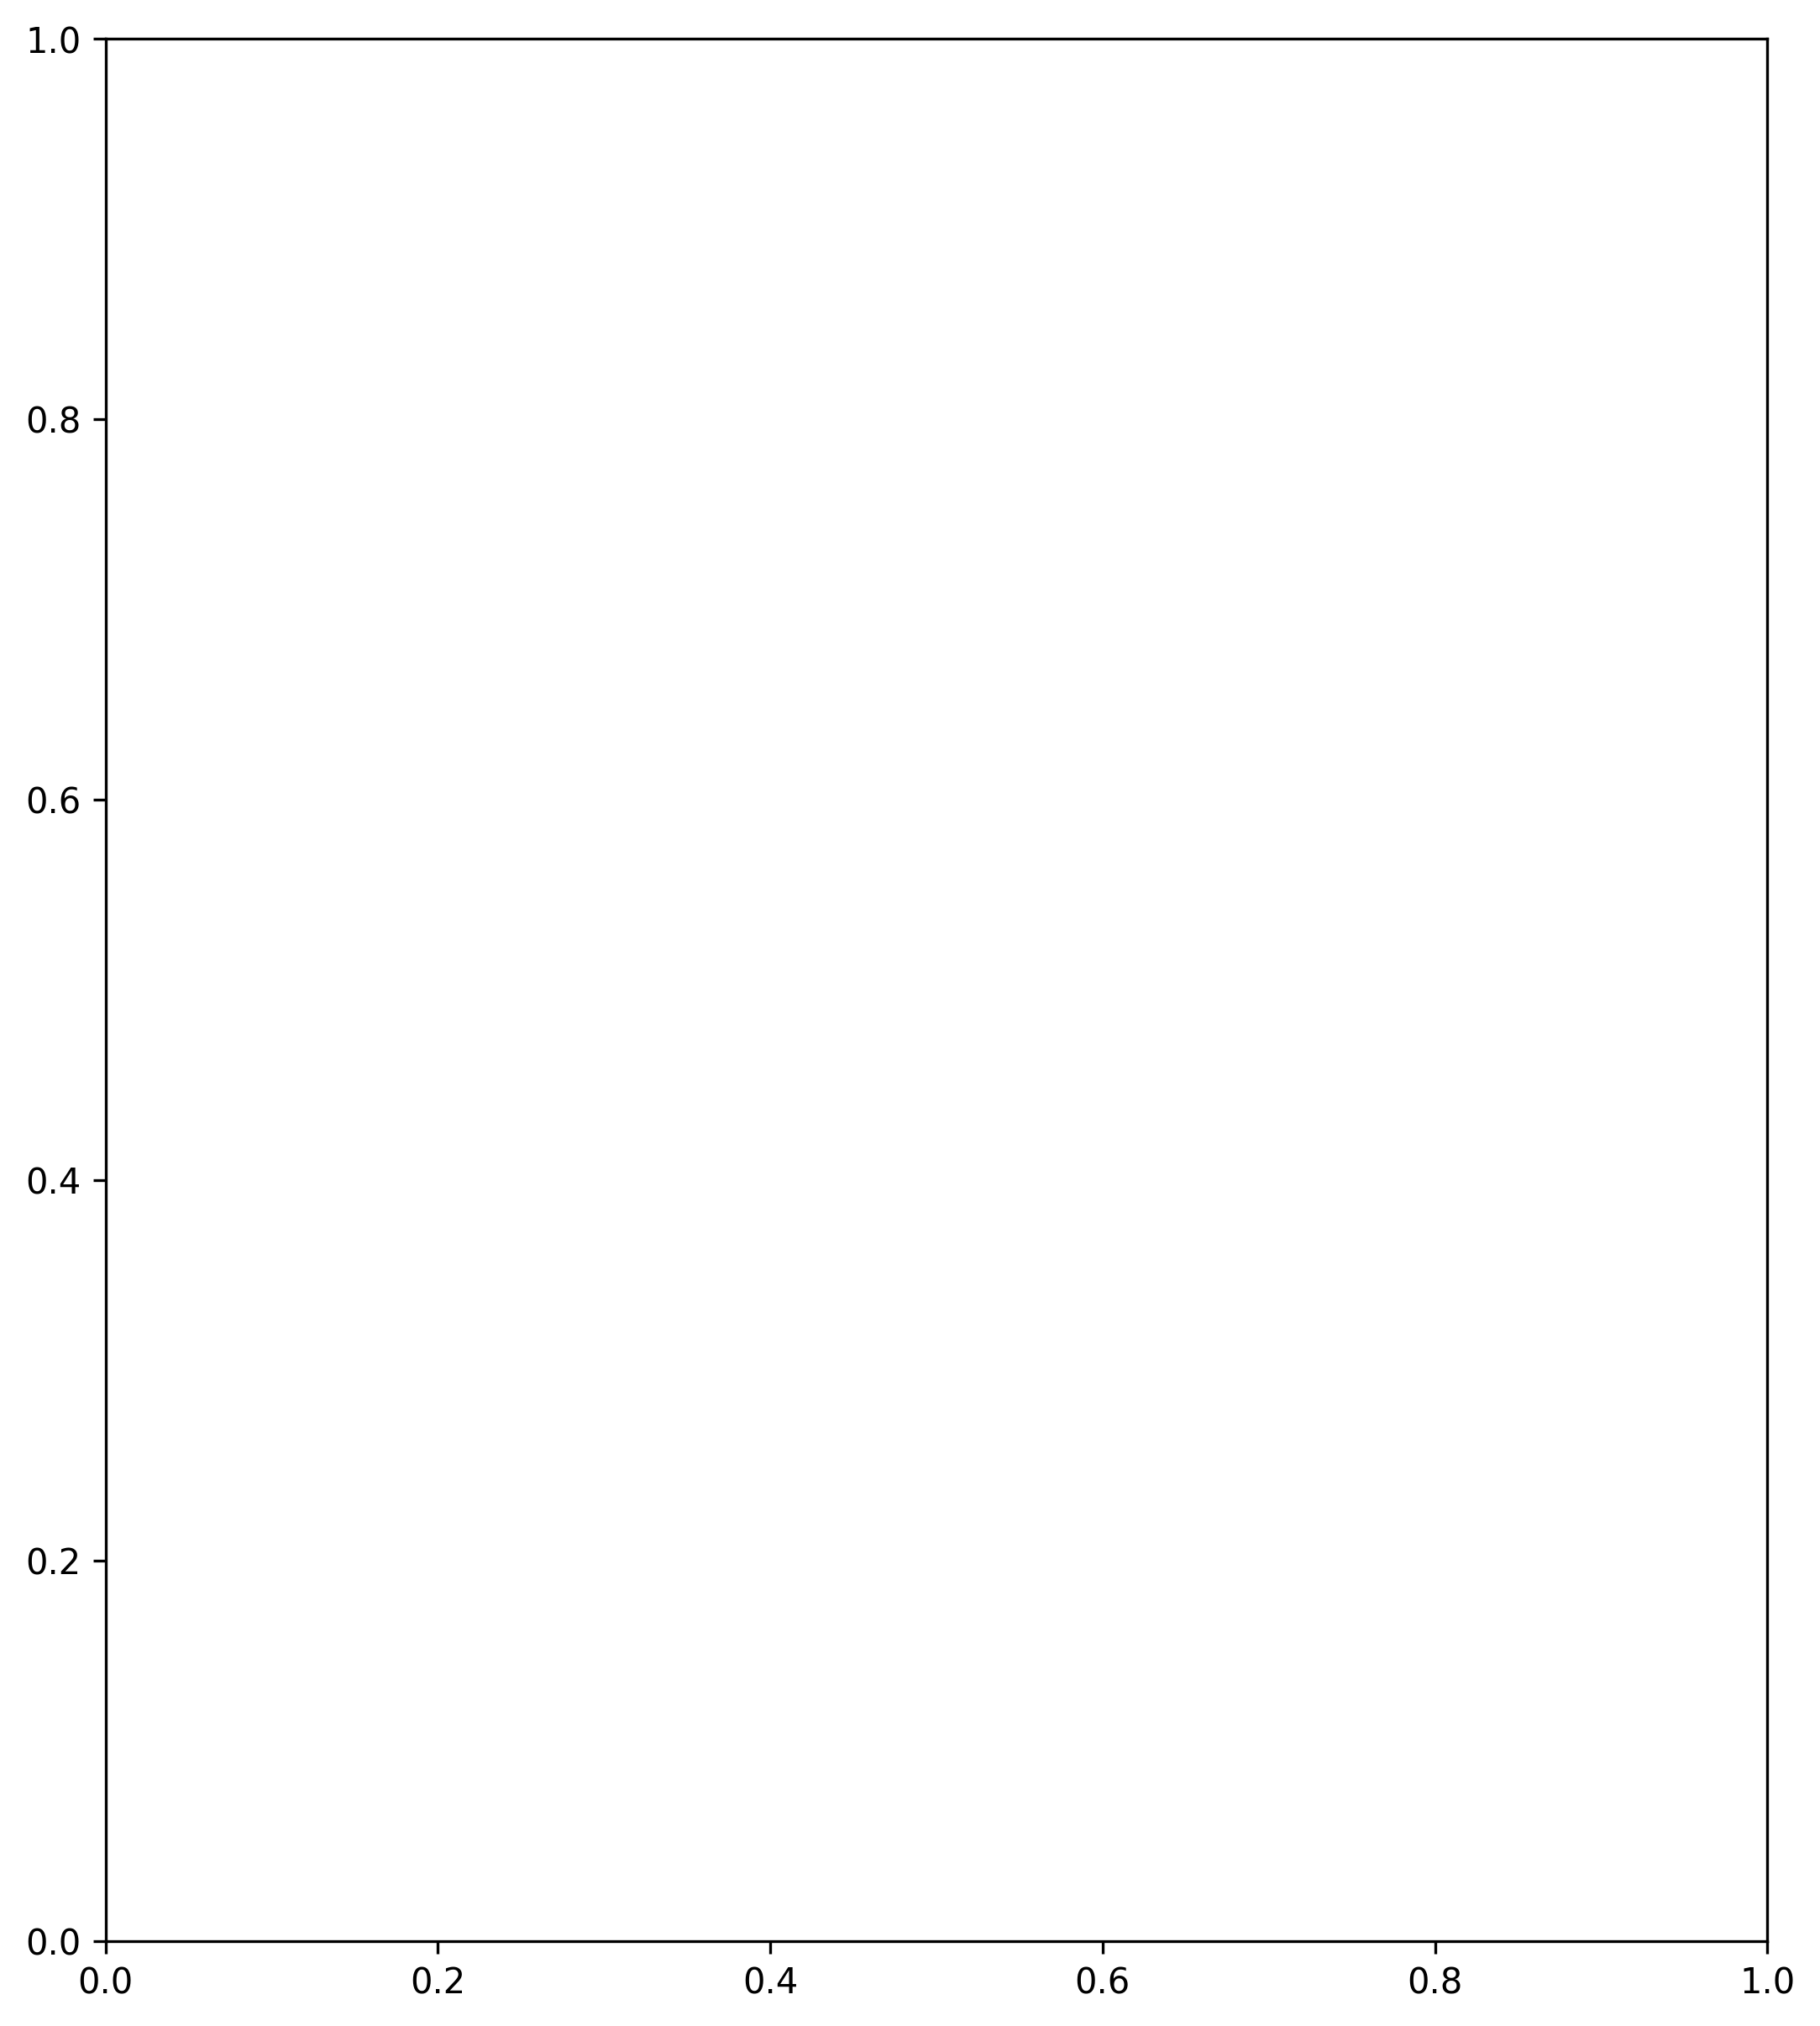

In [ ]:
# Plot Result
fig = plt.figure(figsize=(len(ae_models) * 10, 2 * 5), dpi=300)
for i, (lantent_space, model) in enumerate(zip(latent_spaces, ae_models)):
    ax = plt.subplot(1, len(ae_models), i + 1)

    encoder_model = model.getEncoder()
    latent_value = encoder_model(trainX, batch_size=96, verbose=0, training=True)

    if len(latent_value[0]) > 1:
        tsne = TSNE(n_components=2, init='pca', random_state=0, learning_rate='auto')
        X_tsne = tsne.fit_transform(latent_value)
        ax.title.set_text(str.format('Latent Space {0}', lantent_space))
        plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=trainY)
        plt.colorbar()
    else:
        plt.scatter(latent_value[:, 0], np.zeros(len(latent_value)), c=trainY)
        plt.colorbar()
plt.show(block=False)


## Latent Space Classification
If the data can be can be clustered with the latent space. That means that it should be possible perform image classification with the latent space.

In [ ]:
def plot_value_array(ax, i, predictions_array, true_label):
    true_label = true_label[i]
    ax.grid(False)
    ax.set(ylim=[0, 1])
    thisplot = ax.bar(range(10), predictions_array, color="#777777")
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')


In [ ]:
# Plot Classification Prediction Result
accu_evolutions = []

fig = plt.figure(figsize=(len(ae_models) * 10, 2 * 5), dpi=300)
outer = fig.add_gridspec(1, len(ae_models), wspace=0.05, hspace=0.2, left=0.03, right=0.98, bottom=0.03, top=0.98)

for i, (lantent_space, model) in enumerate(zip(latent_spaces, ae_models)):
    encoder_model = model.getEncoder()
    latent_value = encoder_model.predict(trainX, batch_size=256, verbose=0)

    neigh = KNeighborsClassifier(n_neighbors=7)
    neigh.fit(latent_value, trainY)
    prob = neigh.predict_proba(latent_value)

    # Compute accuracy
    result_classification = [np.argmax(_prob) for _prob in prob]
    correct_class = trainY == result_classification
    accu = correct_class.sum() / len(trainX)
    accu_evolutions.append(accu)

    inner = outer[i].subgridspec(3, 3, wspace=0.02, hspace=0.02)
    #
    ax = plt.Subplot(fig, outer[i])
    ax.set_title(str.format('Latent Space {0} - Probability {1}', lantent_space, accu))
    ax.axis('off')

    axs = inner.subplots()  # Create all subplots for the inner grid.
    for (c, d), ax in np.ndenumerate(axs):
        index = c * 3 + d
        plot_value_array(ax, index, prob[index], trainY)


plt.show(block=False)


In [ ]:
for i, (lantent_space, accu) in enumerate(zip(latent_spaces, accu_evolutions)):
    print(str.format("Latent Space {0} - Accuracy {1}", lantent_space, accu))


## Visualize Latent Space Interpolation
Give that each image creates its respective latent space, that means it should be possible to interpolate between these latent space, and see lies between each latent space point.

In [ ]:
import scipy
import moviepy.editor

In [ ]:
def interpolate(zs, steps):
    out = []
    for i in range(len(zs)-1):
        for index in range(steps):
            fraction = index/float(steps)
            out.append(zs[i+1]*fraction + zs[i]*(1-fraction))
    return out


In [ ]:
def generate_grid_image(model, latent_space, figsize=(8, 8), subplotsize=(3, 3)):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(latent_space, training=False)

    fig = plt.figure(figsize=figsize)
    for i in range(predictions.shape[0]):
        plt.subplot(subplotsize[0], subplotsize[1], i + 1)
        rgb = (predictions[i, :, :, 0:3] + 1.0) / 2.0
        plt.imshow(np.asarray(rgb))
        plt.axis('off')
    plt.close()
    return fig


In [ ]:

fps = 15
duration_sec = 5
smoothing_sec = 1.0
num_frames = 4 * fps

for i, (lantent_space, model) in enumerate(zip(latent_spaces, ae_models)):

    encoder_model = model.getEncoder()
    latent_value0 = encoder_model.predict(trainX[0:16], batch_size=9, verbose=0)

    latent_value1 = encoder_model.predict(trainX[16:32], batch_size=9, verbose=0)

    nr_elemenets = 16

    all_latents = interpolate([latent_value0, latent_value1], num_frames)

    def make_frame(t):
        frame_idx = int(np.clip(np.round(t * fps), 0, num_frames - 1))
        latents = all_latents[frame_idx]

        # Generate figure in respect new latent pace
        fig = generate_grid_image(model.getDecoder(), latents, (5, 5), (4, 4))

        # Convert figure to bitmap.
        fig.canvas.draw()
        data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))

        return data

    gif_filepath = os.path.join(root_dir, str.format('latent_transition_grid_I{0}.gif'.format(root_dir, lantent_space)))
    video_clip = moviepy.editor.VideoClip(make_frame, duration=duration_sec)
    video_clip.write_gif(gif_filepath, fps=fps)


## Presenting Models Neuron Networks

In [ ]:

for i, (lantent_space, model) in enumerate(zip(latent_spaces, ae_models)):
    tf.keras.utils.plot_model(
        model, to_file=str.format(root_dir, str.format('AE_{0}_latent_{1}_model.png', "Cifar100", lantent_space)), show_shapes=True, show_dtype=True,
        show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96, show_layer_activations=True,
        layer_range=None
    )
    ae_model = model.getModel()
    ae_model.summary()
